# Demand Planning KPI Monitor

In [1]:
import pandas as pd
pd.set_option('max_columns', 200)
pd.set_option('max_rows', 200)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib. dates as mdates
%matplotlib inline
from pyspark.sql import SparkSession

import os, sys, gc, datetime, time

import seaborn as sns
plt.style.use('seaborn')
%config InlineBackend.figure_format = 'retina'

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
print('Report generation time:', datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'), end='\n\n')

Report generation time: 2019-09-05 15:11:10



**Other reports saved to Excel:**

* [Consistency by item](report-consistency-items.xlsx)
* [Service level (DC) by item](report_service_level_dc_item.xlsx)

---

In [3]:
## Get parameters, if not given then fall back to default values

if 'ATF_Q_KPI_MONITOR_PARAMETERS' in os.environ:
    print('Using external parameters.')
    _param = os.environ['ATF_Q_KPI_MONITOR_PARAMETERS']
    (DETENTION_START, DETENTION_END, SERVICE_LEVEL_START, SERVICE_LEVEL_END,
     STOCK_LEVEL_START, STOCK_LEVEL_END, CONSISTENCY_START, CONSISTENCY_END) = [
        i.strip() for i in _param.split(',')]
else:
    print('Using default parameters.')
    tfmt = '%Y%m%d'
    _end = datetime.datetime.now().strftime(tfmt)
    _start = (datetime.datetime.now() - datetime.timedelta(days=60)).strftime(tfmt)
    DETENTION_START, DETENTION_END = _start, _end
    SERVICE_LEVEL_START, SERVICE_LEVEL_END = _start, _end
    STOCK_LEVEL_START, STOCK_LEVEL_END = _start, _end
    CONSISTENCY_START, CONSISTENCY_END = _start, _end

print('Detention:', DETENTION_START, DETENTION_END, sep='\t')
print('Stock level:', STOCK_LEVEL_START, STOCK_LEVEL_END, sep='\t')
print('Consistency:', CONSISTENCY_START, CONSISTENCY_END, sep='\t')
print('Service level:', SERVICE_LEVEL_START, SERVICE_LEVEL_END, sep='\t')

Using default parameters.
Detention:	20190707	20190905
Stock level:	20190707	20190905
Consistency:	20190707	20190905
Service level:	20190707	20190905


In [4]:
T0 = time.time()

In [5]:
os.environ["PYSPARK_SUBMIT_ARGS"] = '--jars /data/jupyter/kudu-spark2_2.11-1.8.0.jar pyspark-shell'
warehouse_location = os.path.abspath('spark-warehouse')

spark = SparkSession \
    .builder \
    .appName("Qiang (Charles)") \
    .config("spark.sql.warehouse.dir", warehouse_location) \
    .config("spark.blacklist.enabled", False) \
    .config("hive.exec.compress.output", 'false') \
    .config("spark.num.executors", '15') \
    .config("spark.executor.memory", '30G') \
    .config("spark.executor.cores", '25') \
    .enableHiveSupport() \
    .getOrCreate()

TABLE = 'vartefact.forecast_sprint4_add_dm_to_daily_parquet'

In [6]:
kudu_tables = [
    'lfms.daily_dctrxn', 'lfms.daily_dcstock', 'lfms.ord', 'lfms.daily_shipment'
]

for tbl in kudu_tables:
    spark.read.format('org.apache.kudu.spark.kudu') \
    .option('kudu.master', "dtla1apps11:7051,dtla1apps12:7051,dtla1apps13:7051") \
    .option('kudu.table', f'impala::{tbl}') \
    .load() \
    .registerTempTable('{}'.format(tbl.replace('.', '_')))

In [7]:
def timed_pull(query):
    '''Convenient function to pull data by SQL with timer function.'''
    # with Timer():
    #     foo = spark.sql(query).toPandas()
    foo = spark.sql(query).toPandas()
    #print(f'Dataset size = {foo.shape}, {foo.memory_usage().sum() / 2**20:.2f} MB.')
    return foo

In [8]:
def read_query_and_fetch(sql_path, create_table=False, get_query=False, kudu_replace=None, **query_params):
    with open(sql_path, 'r') as f:
        query = f.read()
    if kudu_replace is not None:
        for k, v in kudu_replace.items():
            query = query.replace(k, v)
    if not create_table:
        ## remove lines with `table`
        q0 = query
        query = '\n'.join([line for line in q0.split('\n')
                           if ('drop table' not in line.lower())
                           and ('create table' not in line.lower())])
    query = query.format(**query_params)
    if get_query:
        return query
    return timed_pull(query)

In [9]:
## Get data

In [10]:
detention_dc = read_query_and_fetch(
    'Queries/kpi_detention_rate_dc.sql',
    # database_name='vartefact', date_start='20190701', date_end='20190730',
    database_name='vartefact', date_start=DETENTION_START, date_end=DETENTION_END,
    kudu_replace={'lfms.daily_dcstock': 'lfms_daily_dcstock'}
)

In [14]:
detention_store = read_query_and_fetch(
    'Queries/kpi_detention_rate_store.sql',
    # database_name='vartefact', date_start='20190701', date_end='20190730',
    database_name='vartefact', date_start=DETENTION_START, date_end=DETENTION_END,
)

In [12]:
stock_level_store = read_query_and_fetch(
    'Queries/kpi_stock_level_store.sql',
    # database_name='vartefact', date_start='20190630', date_end='20190730',
    database_name='vartefact', date_start=STOCK_LEVEL_START, date_end=STOCK_LEVEL_END,
)

In [13]:
stock_level_dc = read_query_and_fetch(
    'Queries/kpi_stock_level_dc.sql',
    # database_name='vartefact', date_start='20190630', date_end='20190730',
    database_name='vartefact', date_start=STOCK_LEVEL_START, date_end=STOCK_LEVEL_END,
    kudu_replace={'lfms.daily_dcstock': 'lfms_daily_dcstock'}
)

In [14]:
# v.forecast_dc_orders
# v.forecast_dc_orders_hist

In [15]:
order_hist = read_query_and_fetch(
    'Queries/kpi_consistency_order_hist.sql',
    # database_name='vartefact', date_start='20190630', date_end='20190730',
    database_name='vartefact', CONSISTENCY_START=CONSISTENCY_START, CONSISTENCY_END=CONSISTENCY_END,
    # kudu_replace={'lfms.daily_dcstock': 'lfms_daily_dcstock'}
)

In [16]:
sl_dc = read_query_and_fetch(
    'Queries/kpi_service_level.sql',
    database_name='vartefact', date_start=SERVICE_LEVEL_START, date_end=SERVICE_LEVEL_END,
    kudu_replace={'lfms.daily_dctrxn': 'lfms_daily_dctrxn', 'lfms.ord': 'lfms_ord'}
)

In [17]:
sl_store = read_query_and_fetch(
    'Queries/kpi_service_level_store.sql',
    database_name='vartefact', date_start=SERVICE_LEVEL_START, date_end=SERVICE_LEVEL_END,
   kudu_replace={'lfms.daily_shipment':'lfms_daily_shipment'}
) 

---

## 1. Detention rate

In [18]:
# detention_dc.head(3)

In [19]:
def plot_detention_dc(df):
    df1 = df.sort_values(by=['rotation', 'date_key']).copy()
    df1['date_dt'] = pd.to_datetime(df1.date_key, format='%Y%m%d')
    fig, ax = plt.subplots(figsize=(12, 3))
    flow_A = df1[df1.rotation == 'A']
    flow_B = df1[df1.rotation == 'B']
    ax.plot(flow_A.date_dt, flow_A.detention_rate, label='Flow A')
    ax.plot(flow_B.date_dt, flow_B.detention_rate, label='Flow B')
    ax.legend()
    ax.set_title('Detention Rate for DC')
    fig.autofmt_xdate()
    print(f'Latest detention rate:')
          # f'flow A {flow_A.iloc[-1, -2]*100:.2f}%, flow B {flow_B.iloc[-1, -2]*100:.2f}%')
    display(detention_dc[['date_key', 'rotation', 'detention_rate']].tail(6).style.hide_index())

### 1.1 Detention rate - DC

Latest detention rate:


date_key,rotation,detention_rate
20190902,A,0.816901
20190902,B,0.673387
20190903,A,0.93662
20190903,B,0.854839
20190904,A,0.915493
20190904,B,0.834677


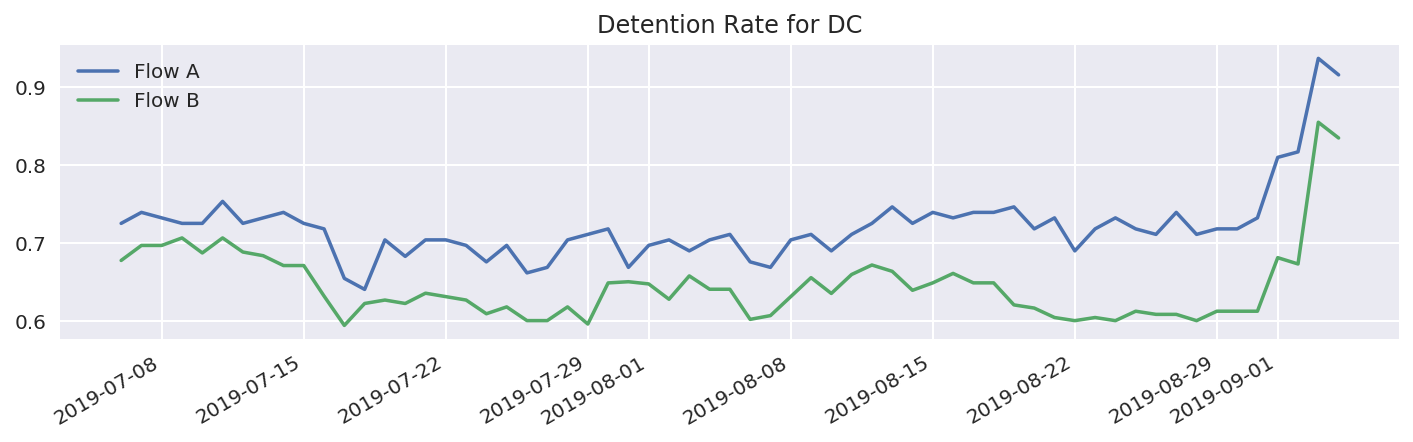

In [20]:
plot_detention_dc(detention_dc)

---

In [21]:
# detention_store.head(3)

In [18]:
def plot_detention_store(df):
    df1 = df.sort_values(by=['rotation', 'date_key', 'store_code']).copy()
    df1['date_dt'] = pd.to_datetime(df1.date_key, format='%Y%m%d')

    # fig, ax = plt.subplots(figsize=(12, 3))
    # for store in df1.store_code.unique():
    #     d = df1[df1.store_code == store]
    #     ax.plot(d.date_dt, d.detention_rate, lw=1)
    # fig.autofmt_xdate()

    dr = df1.groupby(['store_code', 'rotation'])['detention_rate'].mean().reset_index()
    a = dr.loc[dr.rotation == 'A', 'detention_rate'].sort_values().values
    b = dr.loc[dr.rotation == 'B', 'detention_rate'].sort_values().values
    x = dr.loc[dr.rotation == 'X', 'detention_rate'].sort_values().values
    
    fig, axes = plt.subplots(figsize=(16, 4), ncols=3)
    # a.detention_rate.sort_values().plot.bar(ax=axes[0])
    # b.detention_rate.sort_values().plot.bar(ax=axes[1])
    axes[0].plot(a, 'o', ms=6)
    axes[1].plot(b, 'o', ms=6)
    axes[2].plot(x, 'o', ms=6)
    
    axes[0].set_title('Detention rate: Flow A')
    axes[1].set_title('Detention rate: Flow B')
    axes[2].set_title('Detention rate: Flow X')
    
    axes[0].set_ylim(min(0.75, a.min()), 1)
    axes[1].set_ylim(min(0.75, b.min()), 1)
    axes[2].set_ylim(min(0.75, x.min()), 1)
    
    fig.tight_layout()

### 1.2 Detention rate - store

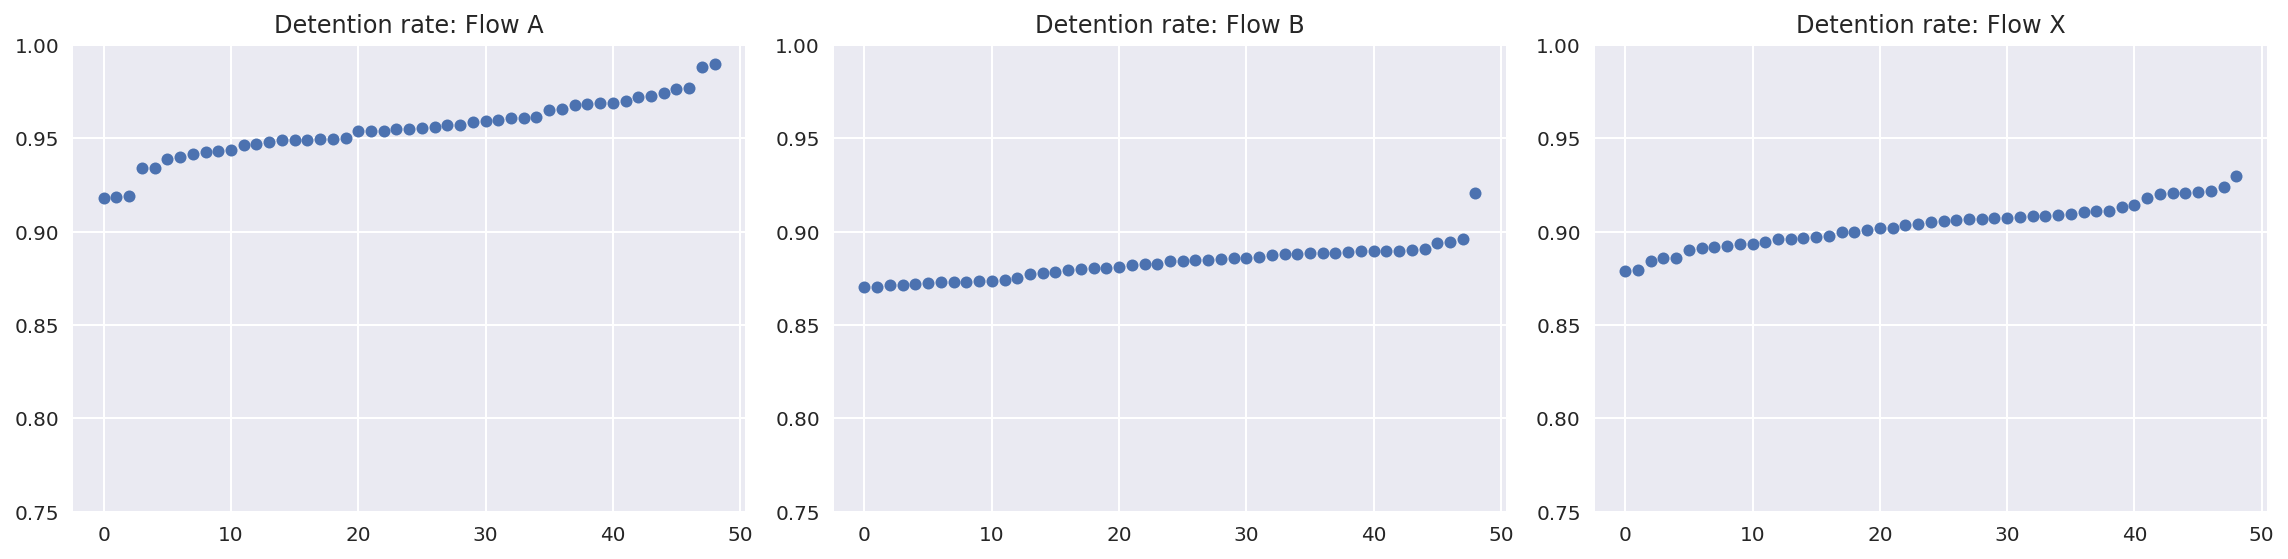

In [19]:
plot_detention_store(detention_store) 

---

## 2 Stock level

### 2.1 Stock level - DC

In [24]:
# dc_dm_items = timed_pull(f'''
# select distinct sub_id
# from vartefact.forecast_dm_dc_orders
# where run_date between "{STOCK_LEVEL_START}" and "{STOCK_LEVEL_END}"
# ''')

In [25]:
# stock_level_dc.sort_values(by=['rotation', 'date_key']).head()

In [26]:
def plot_stock_level_dc(df):
    df1 = df.sort_values(by=['rotation', 'date_key']).copy()
    sl = df1.groupby(['in_dm', 'rotation', 'date_key'])['stock_level'].sum().reset_index()
    sl['date_key'] = pd.to_datetime(sl.date_key, format='%Y%m%d')
    fig, axes = plt.subplots(figsize=(12, 4), ncols=2)
    for i, rotation in enumerate(['A', 'B']):
        axes[i].set_title(f'Rotation = {rotation}')
        for dm in sl.in_dm.unique():
            d = sl[(sl.in_dm == dm) & (sl.rotation == rotation)]
            axes[i].plot(d.date_key, d.stock_level, label="DM" if dm else "Non-DM")
            axes[i].legend()
    fig.autofmt_xdate(); fig.tight_layout()
    # return sl_all_stores

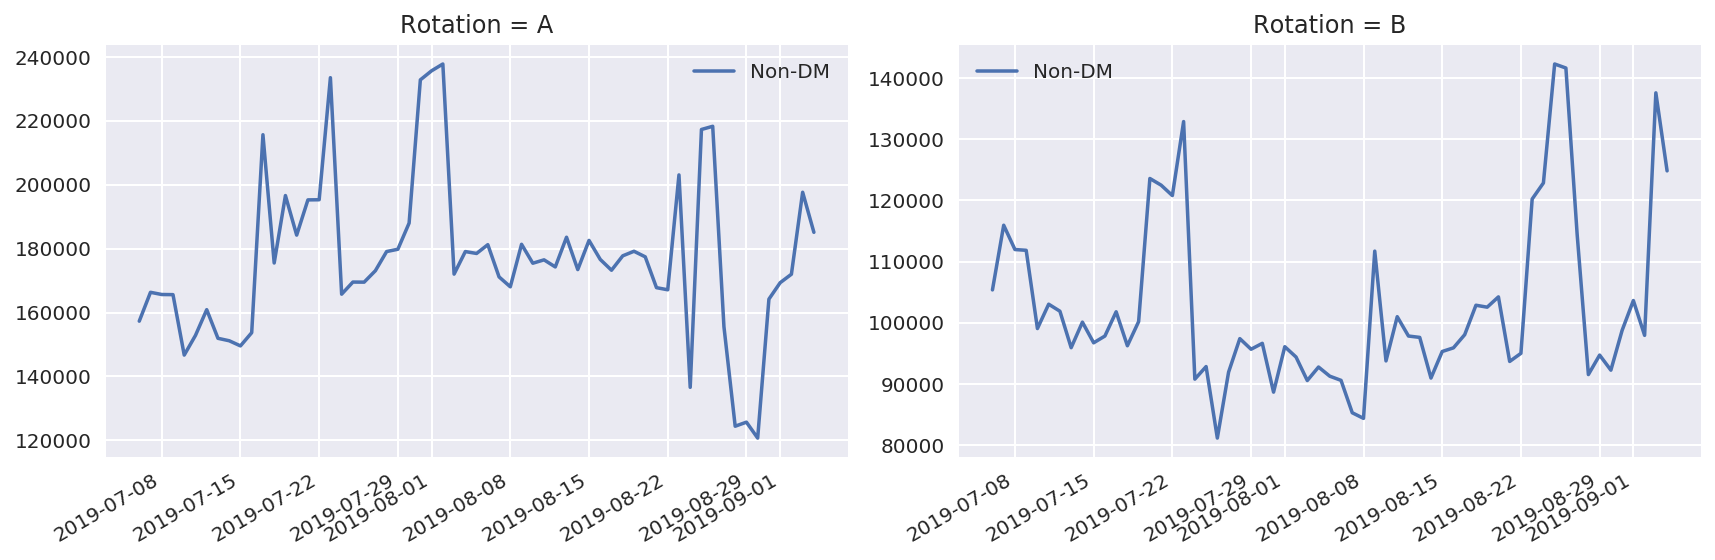

In [27]:
plot_stock_level_dc(stock_level_dc)

In [28]:
## TODO: Aug 22-25, DC stock level is very weird.

---

### 2.2  Stock level - store

In [29]:
# stock_level_store.sort_values(by=['store_code', 'rotation', 'date_key']).head()

In [30]:
def plot_stock_level_store(df):
    df1 = df.sort_values(by=['store_code', 'rotation', 'date_key']).copy()
    sl_all_stores = df1.groupby(['in_dm', 'rotation', 'date_key'])['stock_level'].sum().reset_index()
    sl_all_stores['date_key'] = pd.to_datetime(sl_all_stores.date_key, format='%Y%m%d')
    fig, axes = plt.subplots(figsize=(14, 3.5), ncols=3)
    for i, rotation in enumerate(sl_all_stores.rotation.unique()):
        axes[i].set_title(f'Rotation = {rotation}')
        for dm in sl_all_stores.in_dm.unique():
            d = sl_all_stores[(sl_all_stores.in_dm == dm) & (sl_all_stores.rotation == rotation)]
            axes[i].plot(d.date_key, d.stock_level, label="DM" if dm else "Non-DM")
            axes[i].legend()
    fig.autofmt_xdate(); fig.tight_layout()
    # return sl_all_stores

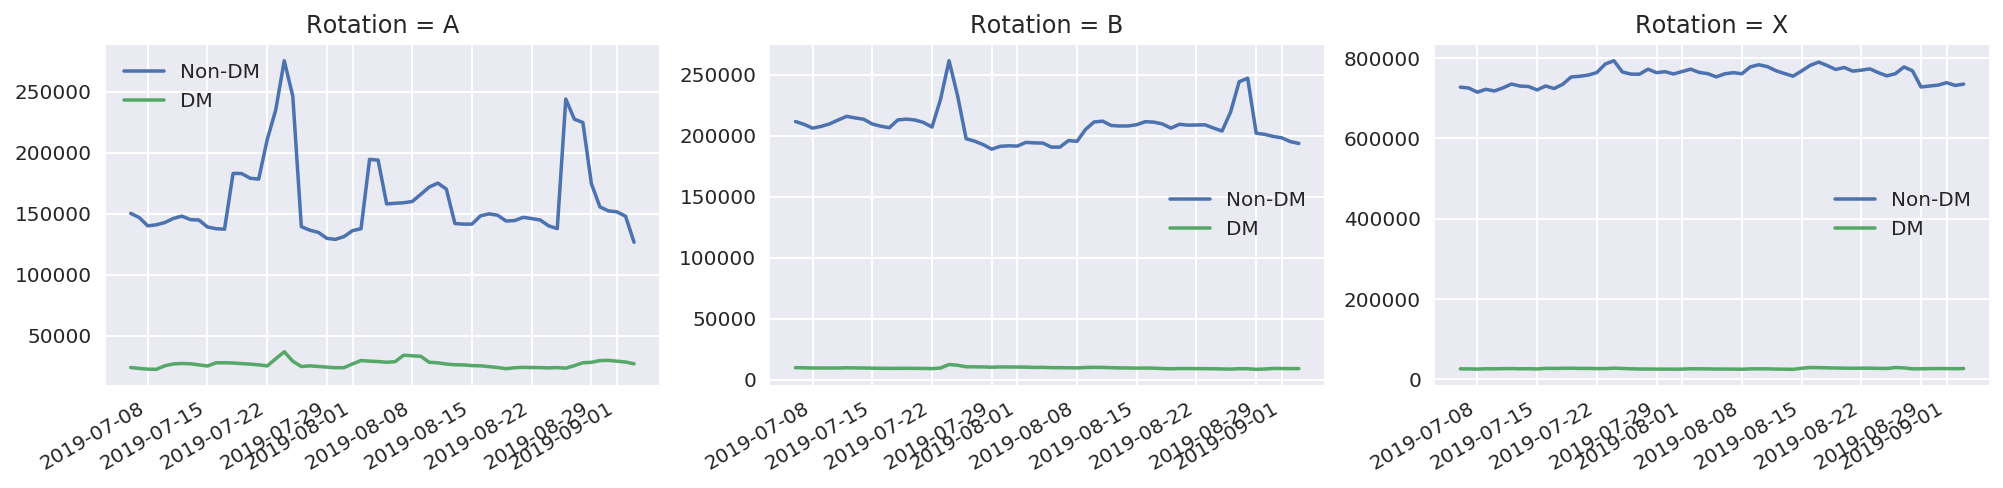

In [31]:
plot_stock_level_store(stock_level_store)

---

## 3  Consistency

In [32]:
def to_dt(x):
    return pd.to_datetime(x, format='%Y%m%d')

def process_for_consistency(sim_hist):
    ord0 = sim_hist[sim_hist.order_day == sim_hist.run_date]
    if ord0.shape[0] == 0:
        return pd.DataFrame()

    chk = ord0[['sub_id', 'item_id', 'item_code', 'item_name', 'barcode', 'rotation',
                'supplier_name', 'order_day', 'order_qty_box']] \
        .rename(columns={'order_qty_box': 'order_qty (box)'}).copy()
    for i in range(2, 8):  # week 2~7
        ord1 = sim_hist[(to_dt(sim_hist.order_day) - to_dt(sim_hist.run_date)).dt.days == int(i * 7)]
        chk = chk.merge(ord1[['sub_id', 'order_day', 'order_qty_box']]
                        .rename(columns={'order_qty_box': f'Week-{i}_before_order_qty'}),
                        on=['sub_id', 'order_day'], how='left')

    ## aggregate by order week
    chk['order_day'] = to_dt(chk.order_day)
    chk['order_week'] = (chk.order_day - pd.to_timedelta(chk.order_day.dt.weekday, unit='days')
                        ).dt.strftime('%Y%m%d')
    chk['Week of year'] = 'W' + chk['order_day'].dt.week.astype(str)
    chk = chk.drop(columns=['order_day', 'sub_id'])
    chk = chk.groupby(['item_id', 'item_code', 'item_name', 'barcode', 'rotation',
                       'supplier_name', 'order_week', 'Week of year']).agg(lambda x: x.sum(skipna=False)).reset_index()

    for i in range(2, 8):  # calculate consistency error
        chk[f'Week-{i}_before_error'] = (
            chk[f'Week-{i}_before_order_qty'] -
            chk['order_qty (box)']) / (chk['order_qty (box)'] + 1.e-6)
        chk[f'Week-{i}_before_run_date'] = (to_dt(chk.order_week) -
                                            datetime.timedelta(days=i*7)).dt.strftime('%m/%d/%Y')

    columns = ['item_id', 'item_code', 'item_name', 'barcode', 'rotation',
               'supplier_name', 'order_week', 'order_qty (box)', 'Week of year']
    for i in range(2, 8):
        columns += [f'Week-{i}_before_run_date', f'Week-{i}_before_order_qty', f'Week-{i}_before_error']
    return chk[columns]

def xavier_method_v2(forecast, actual):
    ''' sum(diff) / sum(forecast) '''
    return (actual - forecast).abs().sum() / (actual.sum() + 1.e-6)

In [42]:
## Only trigger on Sunday
if datetime.datetime.now().weekday() == 6:
    _onstock = order_hist[order_hist.rotation.isin(['A', 'B'])].copy()
    _onstock['order_qty_box'] = np.ceil(_onstock['order_qty'].astype('f8') / _onstock['pcb'].astype('f8'))
    chk_onstock = process_for_consistency(_onstock)

    _xdock = order_hist[order_hist.rotation == 'X'].copy()
    _xdock['order_qty_box'] = np.ceil(_xdock['order_qty'].astype('f8') / _xdock['pcb'].astype('f8'))
    _xdocking = (_xdock.groupby(['order_day', 'run_date', 'sub_id', 'rotation', 'item_id', 'item_code',
                                 'supplier_name', 'barcode', 'item_name'])['order_qty_box'].sum().reset_index())
    chk_xdocking = process_for_consistency(_xdocking)

    if chk_xdocking.shape[0] > 0 and chk_onstock.shape[0] > 0:
        ## Merge, keep only latest week, save to excel
        chk = pd.concat([chk_onstock, chk_xdocking], axis=0)
        chk = chk[chk.order_week == chk.order_week.max()]
        chk.sort_values(by='item_code') \
           .to_excel('report-consistency-items.xlsx',
                     sheet_name='template', index=False)
        ## Print overall consistency (only print week 2)
        flow_a = chk.query('rotation == "A"')
        flow_b = chk.query('rotation == "B"')
        flow_x = chk.query('rotation == "X"')
        print('Consistency (week 2):\nOverall: {:.2f}\nFlow A: {:.2f}%\nFlow B: {:.2f}%\nFlow X: {:.2f}%'
              .format(
                  xavier_method_v2(chk['Week-2_before_order_qty'], chk['order_qty (box)']),
                  xavier_method_v2(flow_a['Week-2_before_order_qty'], flow_a['order_qty (box)']),
                  xavier_method_v2(flow_b['Week-2_before_order_qty'], flow_b['order_qty (box)']),
                  xavier_method_v2(flow_x['Week-2_before_order_qty'], flow_x['order_qty (box)'])
              ))
    else:
        print(f'There is not enough order history data between {CONSISTENCY_START} and '
              f'{CONSISTENCY_END} to calculate consistency.')
else:
    print('Today is not Sunday. Will not calculate consistency.')

Today is not Sunday. Will not calculate consistency.


---

## 4 Service level

In [34]:
# sl.head(3)

In [35]:
def show_service_level_dc(df):
    df1 = df.copy()
    for col in ['trxn_qty_sum', 'basic_order_qty_sum', 'service_level']:
        df1[col] = df1[col].astype('f8')
    # df2 = df1.groupby(['dept_code', 'item_code', 'sub_code', 'holding_code'])[['trxn_qty_sum', 'basic_order_qty_sum']].sum().reset_index()
    # df2['service_level'] = df2['trxn_qty_sum'] / (df2['basic_order_qty_sum'] + 1.e-6)
    # df2 = df2.rename(columns={'trxn_qty_sum': 'received_qty_sum', 'basic_order_qty_sum': 'ordered_qty_sum'})
    df1 = df1.rename(columns={'trxn_qty_sum': 'received_qty_sum', 
                              'basic_order_qty_sum': 'ordered_qty_sum'})
    df1.to_excel('report_service_level_dc_item.xlsx', index=False)
    return df1.groupby('holding_code')[['service_level']].mean().reset_index().style.hide_index()

In [36]:
print('DC service level:')
show_service_level_dc(sl_dc)

DC service level:


holding_code,service_level
002,0.999978
693,0.999965
700,0.999977


In [37]:
def show_service_level_store(df):
    df1 = df.copy()
    for col in ['order_qty_in_sku_sum', 'delivery_qty_in_sku_sum', 'service_level']:
        df1[col] = df1[col].astype('f8')
    # df2 = df1.groupby(['dept_code', 'item_code', 'sub_code', 'holding_code'])[['trxn_qty_sum', 'basic_order_qty_sum']].sum().reset_index()
    # df2['service_level'] = df2['trxn_qty_sum'] / (df2['basic_order_qty_sum'] + 1.e-6)
    # df2 = df2.rename(columns={'trxn_qty_sum': 'received_qty_sum', 'basic_order_qty_sum': 'ordered_qty_sum'})
    df1 = df1.rename(columns={'delivery_qty_in_sku_sum': 'store_received_qty_sum', 
                              'order_qty_in_sku_sum': 'store_ordered_qty_sum'})
    df1.to_excel('report_service_level_store_item.xlsx', index=False)
    return df1.groupby('holding_code')[['service_level']].mean().reset_index().style.hide_index()


In [38]:
print('store service level:')
show_service_level_store(sl_store)

store service level:


holding_code,service_level
002,0.635853
693,0.725167
700,0.771637


In [39]:
T1 = time.time()

---

In [40]:
print(f'Generating monitoring report takes {T1-T0:.2f} seconds.')

Generating monitoring report takes 346.11 seconds.
